# Watchlist Backtest Analysis

Analyze historical Watchlist recommendations to:
- Measure win rate and average returns
- Identify which quality ratings/flags have the strongest edge
- Test Vol R:R prediction accuracy
- Optimize entry/exit strategies

## Setup

In [1]:
from pathlib import Path
from datetime import datetime
import pandas as pd
import numpy as np
import sys
import importlib

# Determine root directory
if Path.cwd().name == 'notebooks':
    ROOT = Path.cwd().parent
else:
    ROOT = Path.cwd()

src_path = ROOT / 'src'

# Add src to path
if str(src_path) not in sys.path:
    sys.path.insert(0, str(src_path))

# Import backtester
if 'backtest_best_trades' in sys.modules:
    import backtest_best_trades
    importlib.reload(backtest_best_trades)
    print("[OK] Reloaded backtest_best_trades module")

from backtest_best_trades import WatchlistBacktest

print(f"[OK] Root directory: {ROOT}")
print(f"[OK] Backtester loaded")

[OK] Root directory: c:\workspace\portfolio_analyser
[OK] Backtester loaded


## Configuration

Set your backtest parameters:
- **category**: Which reports to analyze (sp500, nasdaq100, portfolio, or None for all)
- **holding_period**: Days to hold for performance measurement (7, 14, 30, 60, 90)
- **max_reports**: Maximum number of historical watchlist reports to analyze

In [2]:
# Backtest parameters
CATEGORY = 'nasdaq100'  # sp500, nasdaq100, portfolio, or None for all
HOLDING_PERIOD = 30  # Days to hold
MAX_REPORTS = 200  # Number of historical reports to analyze (2 years of weekly reports)

print(f"Category: {CATEGORY or 'ALL'}")
print(f"Holding Period: {HOLDING_PERIOD} days")
print(f"Max Reports: {MAX_REPORTS}")

Category: nasdaq100
Holding Period: 30 days
Max Reports: 200


## Initialize Backtester

In [3]:
# Initialize
results_dir = ROOT / 'scanner_results' / 'historical_simulation'  # Point to historical simulation folder
backtester = WatchlistBacktest(results_dir)

# Find available reports
files = backtester.find_watchlist_files(CATEGORY)
print(f"\nFound {len(files)} watchlist reports")

if files:
    print("\nMost recent reports:")
    for i, f in enumerate(files[:5], 1):
        date = backtester.extract_date_from_filename(f)
        print(f"  {i}. {f.name} ({date.strftime('%Y-%m-%d')})")
    
    print(f"\nOldest reports:")
    for i, f in enumerate(files[-5:], 1):
        date = backtester.extract_date_from_filename(f)
        print(f"  {i}. {f.name} ({date.strftime('%Y-%m-%d')})")


Found 105 watchlist reports

Most recent reports:
  1. nasdaq100_watchlist_20251229_0900.xlsx (2025-12-29)
  2. nasdaq100_watchlist_20251222_0900.xlsx (2025-12-22)
  3. nasdaq100_watchlist_20251215_0900.xlsx (2025-12-15)
  4. nasdaq100_watchlist_20251208_0900.xlsx (2025-12-08)
  5. nasdaq100_watchlist_20251201_0900.xlsx (2025-12-01)

Oldest reports:
  1. nasdaq100_watchlist_20240129_0900.xlsx (2024-01-29)
  2. nasdaq100_watchlist_20240122_0900.xlsx (2024-01-22)
  3. nasdaq100_watchlist_20240115_0900.xlsx (2024-01-15)
  4. nasdaq100_watchlist_20240108_0900.xlsx (2024-01-08)
  5. nasdaq100_watchlist_20240101_0900.xlsx (2024-01-01)


## Run Backtest

This will:
1. Parse each historical watchlist report
2. Track actual price performance for each recommendation
3. Calculate returns, max gains, max drawdowns, stop hits, target hits

In [4]:
# Run backtest
results = backtester.run_backtest(
    category=CATEGORY,
    max_reports=MAX_REPORTS,
    holding_period=HOLDING_PERIOD
)

print(f"\n[OK] Backtest complete!")
print(f"Total trades analyzed: {len(results)}")

WATCHLIST BACKTEST
Category: nasdaq100
Holding Period: 30 days
Max Reports: 200

Found 105 watchlist reports
Filtered to 102 reports (excluded 3 too recent)

Backtesting: nasdaq100_watchlist_20251208_0900.xlsx
  QCOM   Rank # 1 | GOOD       | 30d return:   +0.0%
  NXPI   Rank # 2 | EXCELLENT  | 30d return:   +0.0%
  MRVL   Rank # 3 | GOOD       | 30d return:   +0.0%
  CSX    Rank # 4 | EXCELLENT  | 30d return:   +0.0%
  GEHC   Rank # 5 | EXCELLENT  | 30d return:   +0.0%
  BKNG   Rank # 6 | EXCELLENT  | 30d return:   +0.0%
  TTWO   Rank # 7 | GOOD       | 30d return:   +0.0%
  AMGN   Rank # 8 | EXCELLENT  | 30d return:   +0.0%

Backtesting: nasdaq100_watchlist_20251201_0900.xlsx
  QCOM   Rank # 1 | GOOD       | 30d return:   +0.0%
  NXPI   Rank # 2 | EXCELLENT  | 30d return:   +0.0%
  MRVL   Rank # 3 | GOOD       | 30d return:   +0.0%
  CSX    Rank # 4 | EXCELLENT  | 30d return:   +0.0%
  GEHC   Rank # 5 | EXCELLENT  | 30d return:   +0.0%
  BKNG   Rank # 6 | EXCELLENT  | 30d return:   +

## View Sample Results

In [5]:
# Display sample results
if not results.empty:
    display_cols = ['ticker', 'rank', 'quality', 'quality_flag', 'vol_rr', 
                   f'return_{HOLDING_PERIOD}d', f'mfe_{HOLDING_PERIOD}d', 
                   f'mae_{HOLDING_PERIOD}d', f'stop_hit_{HOLDING_PERIOD}d']
    
    available_cols = [col for col in display_cols if col in results.columns]
    print("\nSample Results (first 10 trades):")
    display(results[available_cols].head(10))


Sample Results (first 10 trades):


,ticker,rank,quality,quality_flag,vol_rr,return_30d,mfe_30d,mae_30d,stop_hit_30d
0,QCOM,1,GOOD,✓ SAFE ENTRY,4.5,NaN,NaN,NaN,NaN
1,NXPI,2,EXCELLENT,✓ SAFE ENTRY,4.1,NaN,NaN,NaN,NaN
2,MRVL,3,GOOD,✓ SAFE ENTRY,3.3,NaN,NaN,NaN,NaN
3,CSX,4,EXCELLENT,✓ SAFE ENTRY,2.2,NaN,NaN,NaN,NaN
4,GEHC,5,EXCELLENT,✓ IDEAL,1.9,NaN,NaN,NaN,NaN
5,BKNG,6,EXCELLENT,✓ IDEAL,1.6,NaN,NaN,NaN,NaN
6,TTWO,7,GOOD,✓ SAFE ENTRY,1.3,NaN,NaN,NaN,NaN
7,AMGN,8,EXCELLENT,✓ SAFE ENTRY,1.3,NaN,NaN,NaN,NaN
8,QCOM,1,GOOD,✓ SAFE ENTRY,4.5,NaN,NaN,NaN,NaN
9,NXPI,2,EXCELLENT,✓ SAFE ENTRY,4.1,NaN,NaN,NaN,NaN


## Edge Analysis

Analyze results to identify the edge:
- Overall performance
- Performance by Quality Rating
- Performance by Quality Flag
- Performance by Vol R:R tier
- Performance by Rank position

In [6]:
# Generate edge analysis
analysis = backtester.generate_edge_analysis(results, HOLDING_PERIOD)

# Print formatted report
backtester.print_edge_report(analysis)


EDGE ANALYSIS REPORT

                              OVERALL PERFORMANCE                               
--------------------------------------------------------------------------------
Trades: 800
Win Rate: 10.9%
Avg Return: -3.30%
Median Return: -5.00%
Avg Winner: +12.20%
Avg Loser: -5.19%
Win/Loss Ratio: 2.35x
Best Trade: +23.55%
Worst Trade: -7.20%

                          BREAKDOWN BY QUALITY RATING                           
--------------------------------------------------------------------------------

EXCELLENT:
  Trades: 500
  Win Rate: 10.2%
  Avg Return: -3.61%
  Median Return: -5.00%
  Avg Winner: +7.85%
  Avg Loser: -4.91%
  Win/Loss Ratio: 1.60x
  Best Trade: +20.64%
  Worst Trade: -5.00%

GOOD:
  Trades: 300
  Win Rate: 12.0%
  Avg Return: -2.77%
  Median Return: -5.00%
  Avg Winner: +18.36%
  Avg Loser: -5.65%
  Win/Loss Ratio: 3.25x
  Best Trade: +23.55%
  Worst Trade: -7.20%

                           BREAKDOWN BY QUALITY FLAG                            
---------

## Visualizations

### Win Rate by Quality Rating

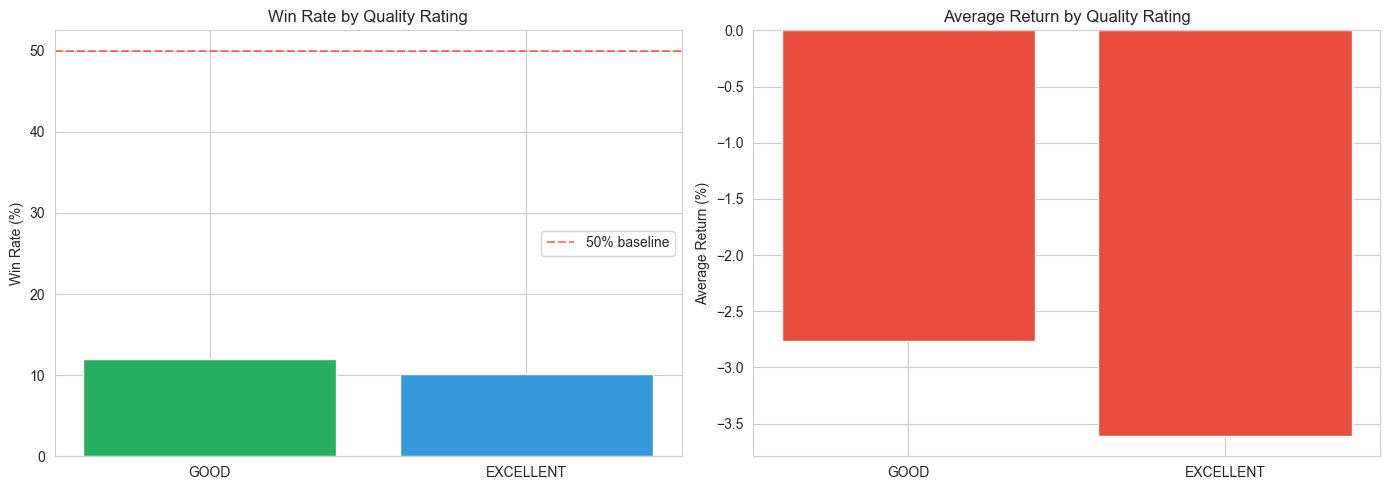

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

# Win rate by quality
quality_stats = []
for quality, stats in analysis.get('by_quality', {}).items():
    if stats:
        quality_stats.append({
            'Quality': quality,
            'Win Rate': stats['win_rate'],
            'Avg Return': stats['avg_return'],
            'Count': stats['count']
        })

if quality_stats:
    df_quality = pd.DataFrame(quality_stats)
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
    
    # Win rate
    ax1.bar(df_quality['Quality'], df_quality['Win Rate'], color=['#27ae60', '#3498db'])
    ax1.set_ylabel('Win Rate (%)')
    ax1.set_title('Win Rate by Quality Rating')
    ax1.axhline(y=50, color='r', linestyle='--', alpha=0.5, label='50% baseline')
    ax1.legend()
    
    # Avg return
    colors = ['#27ae60' if x > 0 else '#e74c3c' for x in df_quality['Avg Return']]
    ax2.bar(df_quality['Quality'], df_quality['Avg Return'], color=colors)
    ax2.set_ylabel('Average Return (%)')
    ax2.set_title('Average Return by Quality Rating')
    ax2.axhline(y=0, color='gray', linestyle='-', alpha=0.3)
    
    plt.tight_layout()
    plt.show()

### Performance by Vol R:R Tier

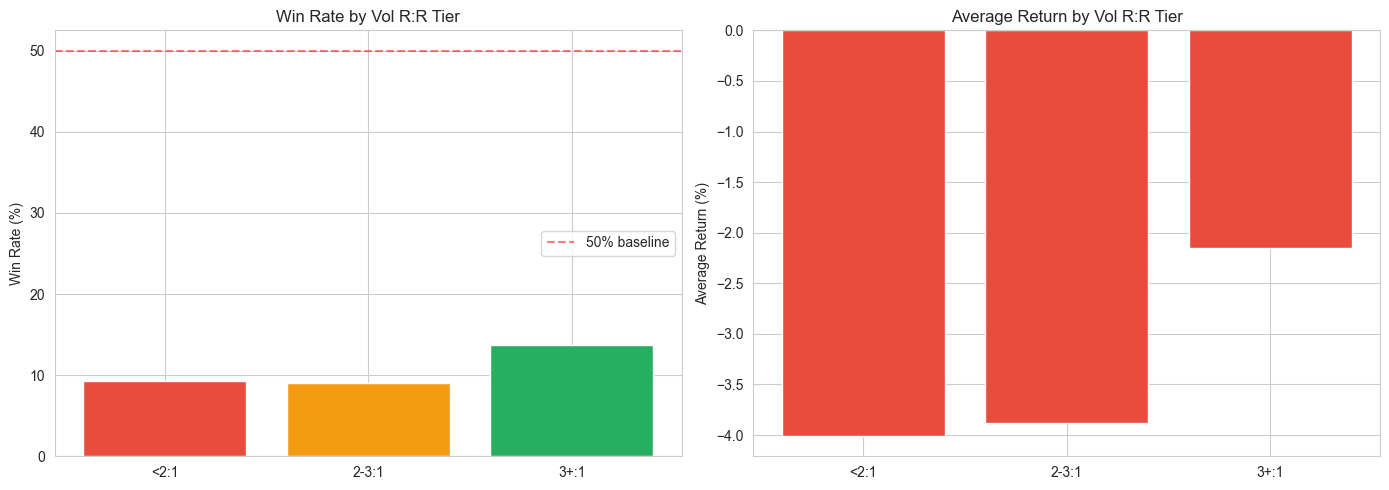

In [8]:
# Win rate by Vol R:R tier
rr_stats = []
for tier, stats in analysis.get('by_vol_rr_tier', {}).items():
    if stats:
        rr_stats.append({
            'Vol R:R': tier,
            'Win Rate': stats['win_rate'],
            'Avg Return': stats['avg_return'],
            'Count': stats['count']
        })

if rr_stats:
    df_rr = pd.DataFrame(rr_stats)
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
    
    # Win rate
    colors = ['#e74c3c', '#f39c12', '#27ae60']
    ax1.bar(df_rr['Vol R:R'], df_rr['Win Rate'], color=colors)
    ax1.set_ylabel('Win Rate (%)')
    ax1.set_title('Win Rate by Vol R:R Tier')
    ax1.axhline(y=50, color='r', linestyle='--', alpha=0.5, label='50% baseline')
    ax1.legend()
    
    # Avg return
    bar_colors = ['#27ae60' if x > 0 else '#e74c3c' for x in df_rr['Avg Return']]
    ax2.bar(df_rr['Vol R:R'], df_rr['Avg Return'], color=bar_colors)
    ax2.set_ylabel('Average Return (%)')
    ax2.set_title('Average Return by Vol R:R Tier')
    ax2.axhline(y=0, color='gray', linestyle='-', alpha=0.3)
    
    plt.tight_layout()
    plt.show()

### Performance by Rank Position

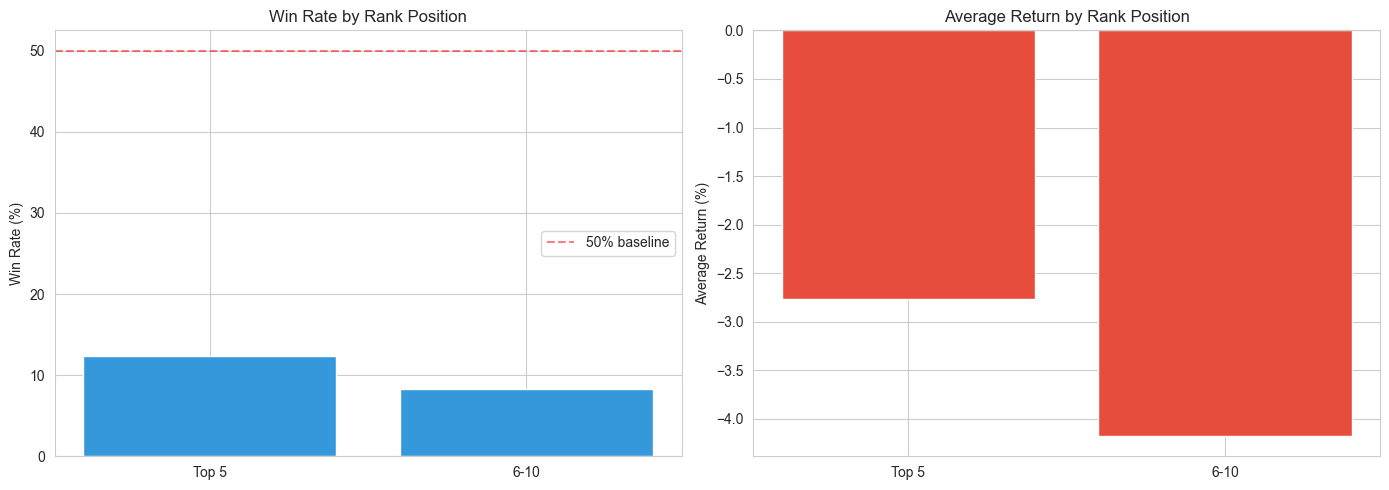

In [9]:
# Win rate by rank tier
rank_stats = []
for tier, stats in analysis.get('by_rank_tier', {}).items():
    if stats:
        rank_stats.append({
            'Rank': tier,
            'Win Rate': stats['win_rate'],
            'Avg Return': stats['avg_return'],
            'Count': stats['count']
        })

if rank_stats:
    df_rank = pd.DataFrame(rank_stats)
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
    
    # Win rate
    ax1.bar(df_rank['Rank'], df_rank['Win Rate'], color='#3498db')
    ax1.set_ylabel('Win Rate (%)')
    ax1.set_title('Win Rate by Rank Position')
    ax1.axhline(y=50, color='r', linestyle='--', alpha=0.5, label='50% baseline')
    ax1.legend()
    
    # Avg return
    bar_colors = ['#27ae60' if x > 0 else '#e74c3c' for x in df_rank['Avg Return']]
    ax2.bar(df_rank['Rank'], df_rank['Avg Return'], color=bar_colors)
    ax2.set_ylabel('Average Return (%)')
    ax2.set_title('Average Return by Rank Position')
    ax2.axhline(y=0, color='gray', linestyle='-', alpha=0.3)
    
    plt.tight_layout()
    plt.show()

### Return Distribution

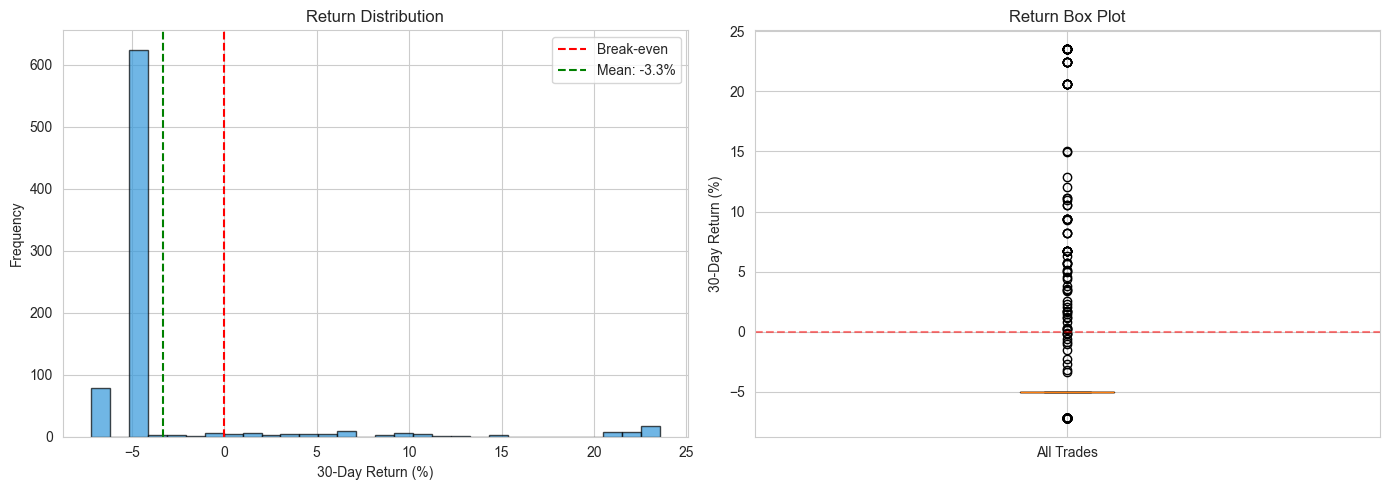

In [10]:
# Return distribution
return_col = f'return_{HOLDING_PERIOD}d'
if return_col in results.columns:
    returns = results[return_col].dropna()
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
    
    # Histogram
    ax1.hist(returns, bins=30, color='#3498db', alpha=0.7, edgecolor='black')
    ax1.axvline(x=0, color='r', linestyle='--', label='Break-even')
    ax1.axvline(x=returns.mean(), color='g', linestyle='--', label=f'Mean: {returns.mean():.1f}%')
    ax1.set_xlabel(f'{HOLDING_PERIOD}-Day Return (%)')
    ax1.set_ylabel('Frequency')
    ax1.set_title('Return Distribution')
    ax1.legend()
    
    # Box plot
    ax2.boxplot(returns, vert=True)
    ax2.axhline(y=0, color='r', linestyle='--', alpha=0.5)
    ax2.set_ylabel(f'{HOLDING_PERIOD}-Day Return (%)')
    ax2.set_title('Return Box Plot')
    ax2.set_xticklabels(['All Trades'])
    
    plt.tight_layout()
    plt.show()

### Stop Hit Analysis


Stop Hit Analysis (30 days):
  Total Trades: 800
  Stops Hit: 716 (89.5%)
  Avg Return (Stopped): -4.81%
  Avg Return (Not Stopped): 9.61%


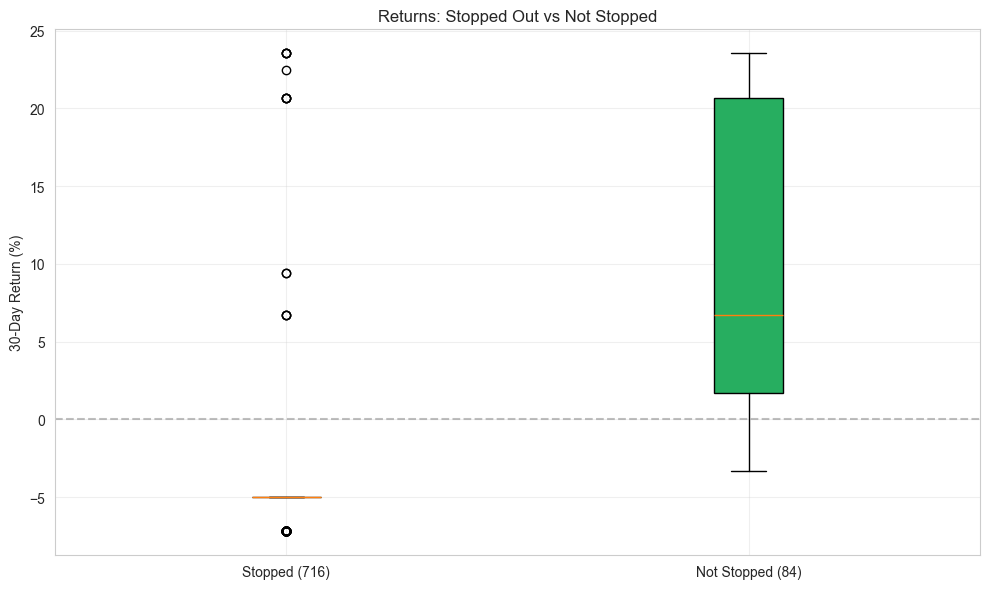

In [11]:
# Stop hit rate analysis
stop_col = f'stop_hit_{HOLDING_PERIOD}d'
if stop_col in results.columns:
    stop_data = results[[stop_col, return_col]].dropna()
    
    # Calculate stats
    total_trades = len(stop_data)
    stops_hit = stop_data[stop_col].sum()
    stop_rate = stops_hit / total_trades * 100 if total_trades > 0 else 0
    
    # Returns for stopped vs not stopped
    stopped_returns = stop_data[stop_data[stop_col] == True][return_col]
    not_stopped_returns = stop_data[stop_data[stop_col] == False][return_col]
    
    print(f"\nStop Hit Analysis ({HOLDING_PERIOD} days):")
    print(f"  Total Trades: {total_trades}")
    print(f"  Stops Hit: {stops_hit} ({stop_rate:.1f}%)")
    print(f"  Avg Return (Stopped): {stopped_returns.mean():.2f}%")
    print(f"  Avg Return (Not Stopped): {not_stopped_returns.mean():.2f}%")
    
    # Visualization
    fig, ax = plt.subplots(figsize=(10, 6))
    
    data_to_plot = [stopped_returns, not_stopped_returns]
    labels = [f'Stopped ({len(stopped_returns)})', f'Not Stopped ({len(not_stopped_returns)})']
    
    bp = ax.boxplot(data_to_plot, labels=labels, patch_artist=True)
    bp['boxes'][0].set_facecolor('#e74c3c')
    bp['boxes'][1].set_facecolor('#27ae60')
    
    ax.axhline(y=0, color='gray', linestyle='--', alpha=0.5)
    ax.set_ylabel(f'{HOLDING_PERIOD}-Day Return (%)')
    ax.set_title('Returns: Stopped Out vs Not Stopped')
    ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

## Save Results

In [12]:
# Save detailed results to CSV
output_file = ROOT / 'backtest_results.csv'
results.to_csv(output_file, index=False)
print(f"[OK] Detailed results saved to: {output_file}")

# Save summary analysis
summary_rows = []

# Overall
overall = analysis.get('overall', {})
if overall:
    summary_rows.append({'Category': 'Overall', 'Segment': 'All', **overall})

# By quality
for quality, stats in analysis.get('by_quality', {}).items():
    if stats:
        summary_rows.append({'Category': 'Quality', 'Segment': quality, **stats})

# By vol rr
for tier, stats in analysis.get('by_vol_rr_tier', {}).items():
    if stats:
        summary_rows.append({'Category': 'Vol R:R', 'Segment': tier, **stats})

# By rank
for tier, stats in analysis.get('by_rank_tier', {}).items():
    if stats:
        summary_rows.append({'Category': 'Rank', 'Segment': tier, **stats})

summary_df = pd.DataFrame(summary_rows)
summary_file = ROOT / 'backtest_summary.csv'
summary_df.to_csv(summary_file, index=False)
print(f"[OK] Summary analysis saved to: {summary_file}")

[OK] Detailed results saved to: c:\workspace\portfolio_analyser\backtest_results.csv
[OK] Summary analysis saved to: c:\workspace\portfolio_analyser\backtest_summary.csv


## Key Insights

Based on the backtest results above, identify:

1. **Does the system have an edge?**
   - Look at overall win rate (>50% is positive)
   - Check average return (positive = edge)
   - Examine win/loss ratio (>1.5x is strong)

2. **Which filters work best?**
   - EXCELLENT vs GOOD quality
   - Quality flags (SAFE ENTRY, IDEAL, etc.)
   - Vol R:R tiers (3+:1 should outperform)
   - Rank position (Top 5 should outperform)

3. **How to improve the edge?**
   - Focus on highest-performing filters only
   - Adjust holding period if needed
   - Test different stop strategies
   - Consider position sizing based on quality